In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.dagcircuit import *
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.tools.visualization import dag_drawer
from qiskit.extensions.standard import CHGate, HGate, CnotGate, CyGate, CzGate
from qiskit.circuit import Measure
from qiskit.circuit.quantumregister import QuantumRegister, Qubit
from qiskit.circuit.classicalregister import ClassicalRegister, Clbit
from qiskit import BasicAer
from qiskit.visualization import plot_histogram
from qiskit import *
import numpy as np
import itertools
import networkx as nx
import pickle
from help_fun import cut_edge

q = QuantumRegister(4, 'q')
c = ClassicalRegister(4, 'c')
circ = QuantumCircuit(q)
circ.h([q[2],q[1]])
circ.x([q[2],q[0]])
circ.y(q[3])
circ.cx(q[0], q[1])
circ.cy(q[2], q[3])
circ.cz(q[1], q[2])
circ.x(q[2])
# circ.barrier()
# circ.measure(q,c)
circ.draw()

original_dag = circuit_to_dag(circ)
print('original_dag has %d connected components' % nx.number_weakly_connected_components(original_dag._multi_graph))
# print(nx.algorithms.connectivity.cuts.minimum_edge_cut(dag._multi_graph))
dag_drawer(original_dag, filename='original_dag.pdf')
circ.draw(output='mpl',filename='original_circ.pdf')

# cut an edge
for node in original_dag.op_nodes():
    if node.name == 'cy':
        source_node = node
    if node.name == 'cz':
        dest_node = node        

cut_dag = cut_edge(original_dag=original_dag, wire=q[2],source_node=source_node, dest_node=dest_node)
print('cut_dag has %d connected components' % nx.number_weakly_connected_components(cut_dag._multi_graph))
dag_drawer(cut_dag, filename='cut_dag.pdf')
dag_to_circuit(cut_dag).draw(output='mpl',filename='cut_circ.pdf')

original_dag has 1 connected components


NetworkXError: The edge 5095244576-5095243904 is not in the graph.

wire: in cutQ[0]
in cutQ[0]

wire: in q[1]
in q[1]
op h
op cx
op cz
out q[1]

wire: in q[0]
in q[0]
op x
op cx
out q[0]



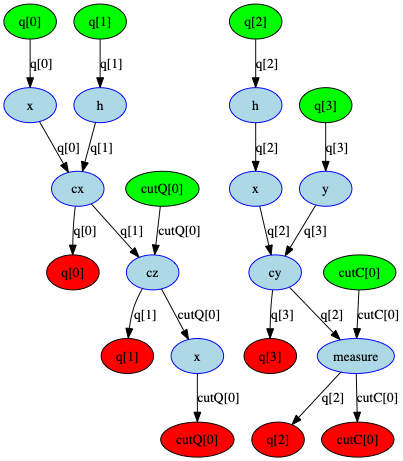

In [38]:
num_components = nx.number_weakly_connected_components(cut_dag._multi_graph)
sub_dags = []
for i in range(num_components):
#     sub_dag = copy.deepcopy(cut_dag)
#     nodes_to_retain = list(nx.weakly_connected_components(sub_dag._multi_graph))[i]
#     all_nodes = list(sub_dag.nodes())
#     qargs = []
#     for node in nodes_to_retain:
#         if node.type == 'in':
#             qargs.append(node)
#     sub_dag._add_op_node(op=Measure(), qargs=None, cargs=None)
#     sub_dags.append(sub_dag)
#     break
    sub_dag = DAGCircuit()
    nodes_to_retain = list(nx.weakly_connected_components(cut_dag._multi_graph))[i]
    for node in nodes_to_retain:
        if node.type == 'in':
            print('wire:',node.type, node.name)
            for child in cut_dag.nodes_on_wire(node.wire):
                print(child.type, child.name)
            print()
    break
        
# dag_drawer(cut_dag)
# pickle.dump([original_dag, cut_dag, sub_dags], open("cuts.p", "wb"))

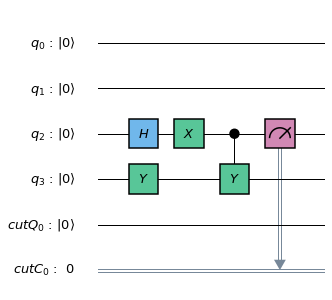

In [5]:
[original_dag, cut_dag, sub_dags] = pickle.load(open( "cuts.p", "rb" ))

dag_drawer(original_dag, filename='original_dag.pdf')
dag_drawer(cut_dag, filename='cut_dag.pdf')
dag_drawer(sub_dags[0], filename='sub_dags_0.pdf')
dag_drawer(sub_dags[1], filename='sub_dags_1.pdf')
dag_to_circuit(sub_dags[0]).draw(output='mpl',filename='sub_circ_0.pdf')
dag_to_circuit(sub_dags[1]).draw(output='mpl',filename='sub_circ_1.pdf')

[QuantumRegister(4, 'q'), QuantumRegister(1, 'cutQ')]


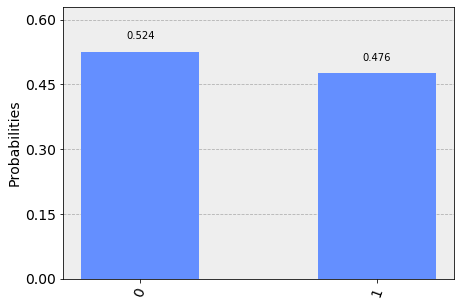

In [6]:
qc = dag_to_circuit(sub_dags[1])
print(qc.qregs)
backend_sim = BasicAer.get_backend('qasm_simulator')
job_sim = execute(qc, backend_sim, shots=1024)
result_sim = job_sim.result()
counts = result_sim.get_counts(qc)
plot_histogram(counts)